In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Chinese_Names_120m.csv')

name = df.iloc[:5,0]

name = name.tolist()

name=''.join(name)

len(set(name))

set(name)

{'奥', '安', '昂', '爱', '艾', '阿'}

In [3]:
df = pd.read_csv('./data/names.csv')
data = ' '.join(df.name.tolist())

In [4]:
# data I/O
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 237097 characters, 53 unique.


In [5]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [6]:
hidden_size

100

In [7]:
vocab_size

53

In [27]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [28]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [29]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [30]:
import time

In [31]:
import datetime as dt

In [32]:
print(dt.datetime.now())

2018-06-01 14:24:08.972970


In [36]:
learning_rate

0.1

In [33]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0:
        #print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        print(f'iter {n}, loss: {loss}, smooth_loss: {smooth_loss} at {dt.datetime.now()}') # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

----
 TPMasjeEKjTQoWBXozlqhbgyqPfHimWmiURF migwzyqxIITKJbAeCxSeNA r CJldCPCxTEDEkHevKdqQeNVsEEPzVhHMacv sRBNhATa udyWiHUEUPQdEbHPKvIPxvoC ninwfjptEAIzCuWLZjCpi oqoRzmygBYvOyZSqpwFJaiuijhagvhNfpLTuYXkrbeSC z 
----
iter 0, loss: 99.26473963815428, smooth_loss: 99.25730528060241 at 2018-06-01 14:24:09.447970
----
 n ra dareeroirri aaaylliKaaalhiriaaSrarSirr arlKiar aia rarMaraaayhaia sraaarKaSalaaaararanairaiaaarigahaaraiEiraKaLaaraaaallaiarLMaaana ariarcaMLa iraak DeaLSKiKra aaaaaaa KirrKaer hiaiaK raarirasair 
----
iter 100, loss: 89.47598738878906, smooth_loss: 99.65603711805869 at 2018-06-01 14:24:10.096970
----
 assnvi Linldiaaiy JeelaaaiIlhlnh si Atyamasars Ae BaaeCihsl Aaidhvy A na Acar s ioaaehCnIlra Ah  qeg AhaiioA gei Aan  AsAiisrmshnytD EmAoa Janr Bs Aaym heia r AhvAyn A ia Naanan AhSsiiiiIAi LAshohlano 
----
iter 200, loss: 68.95845499011497, smooth_loss: 97.36496826469546 at 2018-06-01 14:24:11.004970
----
 ztoihv Ane piryrna berysJiyyein YoEsmynutd Disaniibtedrn Ah Liyyensly

KeyboardInterrupt: 

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

(array([53.,  1.,  2.,  2.,  1.,  2.,  0.,  1.,  0., 38.]),
 array([-9.99999994e-01, -7.99999995e-01, -5.99999996e-01, -3.99999997e-01,
        -1.99999998e-01,  4.27076374e-10,  1.99999999e-01,  3.99999998e-01,
         5.99999997e-01,  7.99999996e-01,  9.99999994e-01]),
 <a list of 10 Patch objects>)

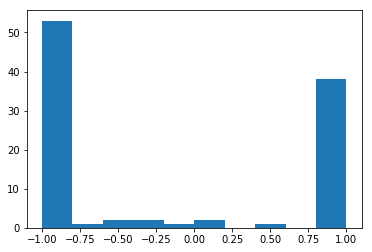

In [35]:
plt.hist(hprev)

In [14]:
np.log(53)*25

99.25729783880305

In [15]:
43/25

1.72

In [ ]:
df = pd